In [1]:
import sys
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## 活性化関数

In [2]:
class ReLU:
    
    def __init__(self):
        self.index = None
        
    def forward(self, A):
        self.index = A < 0
        Z = A.copy()
        Z[self.index] = 0
        return Z
        
    def backward(self, dZ):
        dZ[self.index] = 0
        dA = dZ
        return dA

In [3]:
class Sigmoid:
    
    def __init__(self):
        self.Z = None
        
    def forward(self, X):
        self.Z = self.sigmoid(X)
        return self.Z
        
    def backward(self, dZ):
        dA = dZ * (1.0 - self.sigmoid(self.Z)) * self.sigmoid(self.Z)
        return dA
    
    def sigmoid(self, X):
        return 1.0 / (1.0 + np.exp(-X))

In [4]:
class Tanh:
    
    def __init__(self):
        self.Z = None
        
    def forward(self, A):
        self.Z = np.tanh(A)
        return self.Z
        
    def backward(self, dZ):
        dA = dZ * (1. - np.tanh(self.Z)**2)  
        return dA

In [5]:
class Softmax:
    
    def __init__(self):
        self.Z = None
    
    def forward(self, A):
        
        self.Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return self.Z
        
    def backward(self, dZ):
        dA = dZ
        return dA   

## イニシャライザ

In [6]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma

    
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    
    def B(self, n_nodes1, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [7]:
class XavierInitializer:
    
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = (1 / np.sqrt(n_nodes1)) * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    
    def B(self, n_nodes1, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = (1 / np.sqrt(n_nodes1)) * np.random.randn(1, n_nodes2)    
        return B

In [8]:
class HeInitializer:
    
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = np.sqrt(2 / n_nodes1) * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    
    def B(self, n_nodes1, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.sqrt(2 / n_nodes1) * np.random.randn(1, n_nodes2)        
        return B     

## 最適化手法

In [9]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W = layer.W - self.lr  * layer.dW
        layer.B = layer.B - self.lr  * layer.dB
        
        return layer

In [10]:
class AdaGrad:
    
    def __init__(self, lr=0.01):
        self.lr = lr
        self.hB = 0
        self.hW = 0
        
    def update(self, layer):
        
        self.hB = self.hB + layer.dB * layer.dB
        self.hW = self.hW + layer.dW * layer.dW 
        
        layer.B = layer.B + self.lr *(1/np.sqrt(self.hB )) *layer.dB
        layer.W = layer.W + self.lr *(1/np.sqrt(self.hW )) * layer.dW
        
        return layer

## FC層

In [11]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, act_func):
        
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes1, n_nodes2)
        self.act_func = act_func
        
        self.X = None
        self.dW = None
        self.dB = None
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """      
        self.X = X
        A = X @ self.W + self.B
        
        return A
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dZ = dA @ self.W.T
        self.dB = np.sum(dA, axis=0, keepdims=True)
        self.dW = self.X.T @ dA
        
         # 更新
        self = self.optimizer.update(self)
        return dZ

## ミニバッチ

In [12]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## データセットの用意

In [13]:
import keras
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


## 前処理

In [14]:
# 0から1のfloat型に変換
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [15]:
# one-hot表現 に変換
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [16]:
# 訓練データと検証データに分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 28, 28)
(12000, 28, 28)


In [17]:
print(X_train.reshape(48000,1,28,28).shape) # (48000, 784)

(48000, 1, 28, 28)


In [18]:
X_test = X_train.reshape(48000,1,28,28)

In [19]:
y_test = enc.fit_transform(y_train[:, np.newaxis])
y_test.shape

(48000, 10)

# 【問題1】2次元畳み込み層の作成

1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。  
フォワードプロパゲーションの数式は以下のようになります。  
## $$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$
$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値  
$i$ : 配列の行方向のインデックス  
$j$ : 配列の列方向のインデックス  
$m$ : 出力チャンネルのインデックス  
$K$ : 入力チャンネル数  
$F_{h}, F_{w}$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ  
$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値  
$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み  
$b_m$ : mチャンネルへの出力のバイアス項  
全てスカラーです。  
次に更新式です。1次元畳み込み層や全結合層と同じ形です。  
## $$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$
$\alpha$ : 学習率  
$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$ に関する損失 $L$ の勾配  
$\frac{\partial L}{\partial b_{m}}$ : $b_{m}$ に関する損失 $L$ の勾配  
勾配 $\frac{\partial L}{\partial w_{s,t,k,m}}$ や $\frac{\partial L}{\partial b_{m}}$ を求めるためのバックプロパゲーションの数式が以下である。  
## $$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$
$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値  
$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ  
前の層に流す誤差の数式は以下です。  
## $$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$
$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値  
$M$ : 出力チャンネル数  
ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。

In [20]:
class Conv2d:

    def __init__(self, FN, C, FH, FW, stride=1, padding=0, optimizer=None, act_func=None, pool_func=None, flatten_func=None):

        self.W = np.sqrt(2.0/(28+28))*np.random.randn(FN, C, FH, FW) # (出力チャンネル数、入力チャンネル数、フィルタサイズ)
        self.B = np.sqrt(2.0/(28+28))*np.random.randn(FN) # （出力チャンネル数）
        
        self.stride = 1
        self.padding = 0
        
        # 中間データ（backward時に使用）
        self.X = None   
        self.X_col = None
        self.W_col = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.dB = None
        
        self.act_func = act_func
        self.pool_func = pool_func
        
        self.optimizer = optimizer
        self.flatten_func = flatten_func

    def forward(self, X):
        
        FN, C, FH, FW = self.W.shape
        N, C, H, W = X.shape
        out_h = 1 + int((H + 2*self.padding - FH) / self.stride)
        out_w = 1 + int((W + 2*self.padding - FW) / self.stride)
    
        X_col = self.im2col(X, FH, FW, self.stride, self.padding)
        W_col = self.W.reshape(FN, -1).T

        A = np.dot(X_col, W_col) + self.B
        A = A.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.X = X
        self.X_col = X_col
        self.W_col = W_col

        return A

    def backward(self, dA):
        
        FN, C, FH, FW = self.W.shape
        dA = dA.transpose(0,2,3,1).reshape(-1, FN)

        self.dB = np.sum(dA, axis=0)
        self.dW = np.dot(self.X_col.T, dA)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dZ_col = np.dot(dA, self.W_col.T)
        dZ = self.col2im(dZ_col, self.X.shape, FH, FW, self.stride, self.padding)
        
         # 更新
        self = self.optimizer.update(self)
        return dZ
    
    def im2col(self, input_data, filter_h, filter_w, stride=1, pad=0):

        N, C, H, W = input_data.shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1

        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        return col    
    

    def col2im(self, col, input_shape, filter_h, filter_w, stride=1, padding=0):

        N, C, H, W = input_shape
        out_h = (H + 2*padding - filter_h)//stride + 1
        out_w = (W + 2*padding - filter_w)//stride + 1
        col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*padding + stride - 1, W + 2*padding + stride - 1))
        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, padding:H + padding, padding:W + padding]    



# 【問題2】2次元畳み込み後の出力サイズ

畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。
## $$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$
$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ


$h$ が高さ方向、 $w$ が幅方向である

In [21]:
def calc_n_output(n_input, n_filter, n_padding, n_stride):
    n_output = int(1 + (n_input + 2 * n_padding -  n_filter) / n_stride)
    return n_output

# 【問題3】最大プーリング層の作成

最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。
## $$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$
$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 $S_{h}×S_{w}$ の範囲内の行（p）と列（q）  
$S_{h}, S_{w}$ : 高さ方向（h）と幅方向（w）のストライドのサイズ  
$(p,q)\in P_{i,j}$ : $P_{i,j}$ に含まれる行（p）と列（q）のインデックス  
$a_{i,j,m}$ : 出力される配列のi行j列、kチャンネルの値  
$x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値  
ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。  
バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス $(p,q)$ を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

In [22]:
class MaxPool2D:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        col = self.im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        #flattenは構造を１次元配列に入れ直すこと
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = self.col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx
    
    def im2col(self, input_data, filter_h, filter_w, stride=1, pad=0):

        N, C, H, W = input_data.shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1

        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        return col    
    

    def col2im(self, col, input_shape, filter_h, filter_w, stride=1, padding=0):

        N, C, H, W = input_shape
        out_h = (H + 2*padding - filter_h)//stride + 1
        out_w = (W + 2*padding - filter_w)//stride + 1
        col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*padding + stride - 1, W + 2*padding + stride - 1))
        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, padding:H + padding, padding:W + padding]        
    

# 【問題4】（アドバンス課題）平均プーリングの作成

平均プーリング層のクラスAveragePool2Dを作成してください。  
範囲内の最大値ではなく、平均値を出力とするプーリング層です。  
画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。  

In [23]:
class AveragePool2D:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_average = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)


        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_average = np.argaverage(col, axis=1)
        out = np.average(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_average = arg_average

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        daverage = np.zeros((dout.size, pool_size))
        #flattenは構造を１次元配列に入れ直すこと
        daverage[np.arange(self.arg_average.size), self.arg_average.flatten()] = dout.flatten()
        daverage = daverage.reshape(dout.shape + (pool_size,)) 

        dcol = daverage.reshape(daverage.shape[0] * daverage.shape[1] * daverage.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

# 【問題5】平滑化

平滑化するためのFlattenクラスを作成してください。  
フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。  
この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [24]:
class Flatten:

    def forward(self, Z, N):
        
        self.C = Z.shape[1]
        self.OH = Z.shape[2]
        self.OW = Z.shape[3]

        return Z.reshape(N, -1)
        
    def backward(self, dZ, N, C):
        
        return dZ.reshape(N, self.C, self.OH, self.OW)

# 【問題6】学習と推定

In [25]:
class Scratch2dCNNClassifier:
    
    def __init__(self, epoch, batch_size, lr, optimizer='SGD', sigma=0.1, stride=1, padding=0):
        self.epoch = epoch                       # エポック数
        self.batch_size = batch_size      # バッチ数
        self.lr = lr                                        # 学習率
        self.optimizer = optimizer            # 勾配法
        self.sigma = sigma                        # シグマ（初期化用）
        
        self.layers = []                               # レイヤーの配列を初期化
        self.loss = []                                   # lossの配列を初期化
        
        self.stride = stride
        self.padding = padding
    
    # Convolutionレイヤーの追加
    def add_convolution(self, FN=1, C=1, FH=3, FW=3, activation='relu', pooling='max', flatten=False, pool_h=2, pool_w=2):       
        
        if activation == 'relu':
            act_func = ReLU()        
        elif activation is None:
            act_func = None
            
        if pooling == 'max':
            pool_func = MaxPool2D(pool_h, pool_w, self.stride, self.padding)
        elif pooling == 'avarage':
            pool_func = AveragePool2D(pool_h, pool_w, self.stride, self.padding)
        else:
            pool_func = None
            
        if flatten is True:
            flatten_func = Flatten()
        else:
            flatten_func = None

        # Convolutionレイヤーの追加
        self.layers.append(Conv2d(FN, C, FH, FW, self.stride, self.padding, SGD(self.lr), act_func, pool_func, flatten_func))
    
    # Affineレイヤーの追加
    def add_affine(self, n_nodes1, n_nodes2, activation):
        
        # 選択した活性化関数により「イニシャライザ」と「活性化関数」のオブジェクトを作成
        if activation == 'relu':
            initializer = HeInitializer()
            act_func = ReLU()
        elif activation == 'sigmoid':
            initializer = XavierInitializer()
            act_func = Sigmoid()
        elif activation == 'tanh':
            initializer = XavierInitializer()
            act_func = Tanh()
        elif activation == 'softmax':
            initializer = SimpleInitializer(self.sigma)
            act_func = Softmax()

        # 選択した勾配法により「勾配法」のオブジェクトを作成
        if self.optimizer == 'SGD':
            optimizer = SGD(self.lr)
        elif self.optimizer == 'AdaGrad':
            optimizer = AdaGrad(self.lr)
        
        # Affineレイヤーの追加
        self.layers.append(FC(n_nodes1, n_nodes2, initializer, optimizer, act_func))
        
        
    def fit(self, X, y):
        
        for e in np.arange(self.epoch):
            
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size) # ミニバッチに分割
            
            for mini_X_train, mini_y_train in get_mini_batch:
                
                # ★★★★ フォワードプロパゲーション ★★★★
                Z = mini_X_train # 初期値を代入
                
                for layer in self.layers:
                    
                    # Convolutionレイヤーの場合
                    if type(layer) is Conv2d:
                        
                        # 畳み込み層
                        A = layer.forward(Z)
                        
                        # 活性化関数
                        if layer.act_func is not None:
                            A = layer.act_func.forward(A)
                            
                        # プーリング層
                        if layer.pool_func is not None:
                            Z = layer.pool_func.forward(A)
                        
                        # 平滑化
                        if layer.flatten_func is not None:
                                Z = layer.flatten_func.forward(Z, self.batch_size)
                        
                    # Affineレイヤーの場合
                    elif type(layer) is FC:
                        
                        # FC層
                        A = layer.forward(Z)
                        
                        # 活性化関数
                        Z = layer.act_func.forward(A)
                        
                    
                # ★★★★ 交差エントロピー誤差 ★★★★                
                self.loss.append(self.cross_entropy_error(Z,  mini_y_train))                    
                    
                    
                #  ★★★★ バックプロパゲーション ★★★★
                dZ = Z - mini_y_train
                
                for layer in self.layers[::-1]:
                    
                    if type(layer) is Conv2d:
                        
                        # 平滑化
                        if layer.flatten_func is not None:
                                dZ = layer.flatten_func.backward(dZ, self.batch_size, 1)                        
                        
                        # プーリング層
                        if layer.pool_func is not None:
                            dA = layer.pool_func.backward(dZ)
                        
                        # 活性化関数
                        if layer.act_func is not None:
                            dA = layer.act_func.backward(dA)

                        # 畳み込み層
                        dZ = layer.backward(dA)                            
                        
                    elif type(layer) is FC:
                        
                        # 活性化関数
                        dA = layer.act_func.backward(dZ)
                        
                        # FC層
                        dZ = layer.backward(dA)
                                           
             
    def predict(self, X):
    
        Z = X # 初期値を代入
        
        for layer in self.layers:
            
            # Convolutionレイヤーの場合
            if type(layer) is Conv2d:

                # 畳み込み層
                A = layer.forward(Z)
                
                # 活性化関数
                if layer.act_func is not None:
                    A = layer.act_func.forward(A)
                
                # プーリング層
                if layer.pool_func is not None:
                    Z = layer.pool_func.forward(A)

                # 平滑化
                if layer.flatten_func is not None:
                        Z = layer.flatten_func.forward(Z, X.shape[0])
                
            # Affineレイヤーの場合
            elif type(layer) is FC:

                # FC層
                A = layer.forward(Z)
                
                # 活性化関数
                Z = layer.act_func.forward(A)
                
        y_pred = np.argmax(Z,axis=1)     
    
        return y_pred
    
    def cross_entropy_error(self, y_pred,  y_true):
        delta = 1e-7
        return -np.sum(y_true * np.log(y_pred + delta)) / self.batch_size        

In [37]:
clf=Scratch2dCNNClassifier(epoch=5, batch_size=20, lr=0.005, optimizer='SGD', sigma=0.1, stride=1, padding=0)
clf.add_convolution(FN=1, C=1, FH=3, FW=3, activation=None, pooling='max', flatten=True, pool_h=2, pool_w=2)
clf.add_affine(n_nodes1=625, n_nodes2=200, activation = 'sigmoid')
clf.add_affine(n_nodes1=200, n_nodes2=10, activation = 'softmax')

In [38]:
clf.fit(X_test, y_test)

/Users/chidori/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [39]:
y_pred = clf.predict(X_val.reshape(12000,1,28,28))

/Users/chidori/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [40]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.8731666666666666

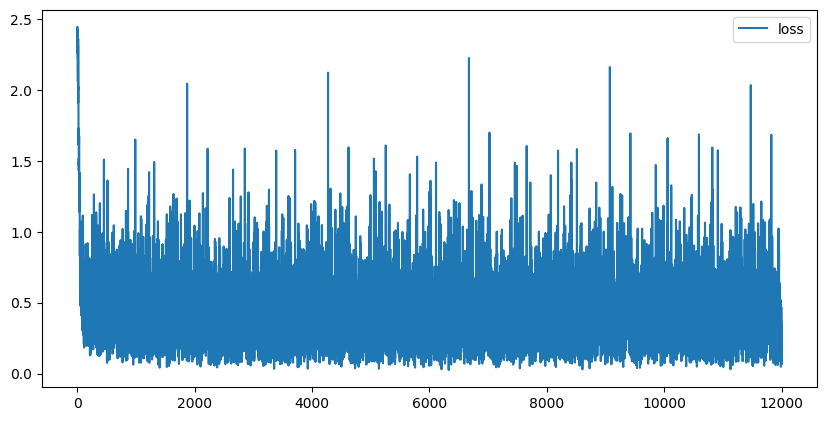

In [41]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(clf.loss, label='loss')
plt.legend()

作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。  
精度は低くともまずは動くことを目指してください。 

# 【問題7】（アドバンス課題）LeNet

CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。

サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。  
畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1  
ReLU  
最大プーリング  
畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1  
ReLU  
最大プーリング  
平滑化  
全結合層　出力ノード数120  
ReLU  
全結合層　出力ノード数84  
ReLU  
全結合層　出力ノード数10  
ソフトマックス関数  

In [31]:
clf=Scratch2dCNNClassifier(epoch=5, batch_size=20, lr=0.005, optimizer='SGD', sigma=0.1, stride=1, padding=0)
clf.add_convolution(FN=6, C=1, FH=5, FW=5, activation='relu', pooling='max', flatten=False, pool_h=2, pool_w=2)
clf.add_convolution(FN=16, C=6, FH=5, FW=5, activation='relu', pooling='max', flatten=True, pool_h=2, pool_w=2)
clf.add_affine(n_nodes1=5184, n_nodes2=120, activation = 'relu')
clf.add_affine(n_nodes1=120, n_nodes2=84, activation = 'relu')
clf.add_affine(n_nodes1=84, n_nodes2=10, activation = 'softmax')

In [32]:
clf.fit(X_test, y_test)

In [33]:
y_pred = clf.predict(X_val.reshape(12000,1,28,28))

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.9868333333333333

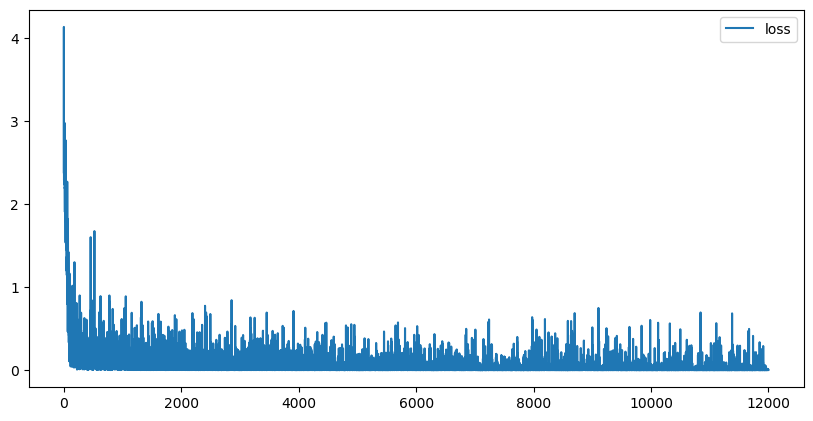

In [35]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(clf.loss, label='loss')
plt.legend()

# 【問題8】（アドバンス課題）有名な画像認識モデルの調査

CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。  
どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。  

### LeNet
1998年に提案された、現Facebook AI ResearchのYann LeCun先生によるCNNの元祖となるネットワーク。畳込み層とプーリング層を交互に重ねたネットワークで、この時点ですでに現在使われているアーキテクチャとほぼ同じ形になっている。活性化関数がシグモイド関数な点、プーリング層がMaxプーリングではなくサブサンプリングで縮小している点などが特徴。
### AlexNet
LeNetが登場してから14年ほど経った2012年に発表された、トロント大のHinton教授を含むチームによるネットワーク。ImageNetを使った画像認識コンペILSVRCで圧倒的な成績を残し、ディープラーニングの火付け役となった。  
畳み込み層とプーリング層、そして正規化層と呼ばれる局所的正規化(LRN ― Local Response Normalization)を行う層を重ねた14層のネットワーク。活性化関数はReLUで、Dropoutを用いているのが特徴。他にもData Augmentationなども行っていて、現在使われているCNNでの主要な手法がこの時点ですでに活用されている。
### VGG
2014年のILSVRCで2位になった、オックスフォード大学のVGGチームのネットワーク。AlexNetをより深くした、畳み込み層とプーリング層から成るどノーマルなCNNで、重みがある層(畳み込み層や全結合層)を16層、もしくは19層重ねたもの。それぞれVGG16やVGG19と呼ばれる。  
小さいフィルターを持つ畳み込み層を2〜4つ連続して重ね、それをプーリング層でサイズを半分にするというのを繰り返し行う構造が特徴。  
### GoogLeNet
前述したとおり、2014年のコンペで1位になったアーキテクチャ。このアーキテクチャは通常の入力層から出力層まで縦一直線な構造ではなく、インセプション構造と呼ばれる横にも層が広がる構造をしている。このため、Inceptionモデルとも呼ばれる。  
横への層の広がりは、異なるサイズのフィルターの畳み込み層を複数横に並べて、それを結合するという形になっている。  
### ResNet
Microsoft(当時)のKaiming He氏による、2015年のILSVRCで優勝したネットワーク。それまでのネットワークでは層を深くしすぎると性能が落ちるという問題があったが、それを「スキップ構造」によって解決し、152層もの深さ(前年優勝のGoogLeNetでも22層)を実現した。  
スキップ構造は、ある層への入力をバイパスし層をまたいで奥の層へ入力してしまうというもので、これにより勾配の消失や発散を防止し、超多層のネットワークを実現している。  

# 【問題9】出力サイズとパラメータ数の計算

CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。  
また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。  
以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。  
1.  
入力サイズ : 144×144, 3チャンネル  
フィルタサイズ : 3×3, 6チャンネル  
ストライド : 1  
パディング : なし  
2.  
入力サイズ : 60×60, 24チャンネル  
フィルタサイズ : 3×3, 48チャンネル  
ストライド　: 1  
パディング : なし  
3.  
入力サイズ : 20×20, 10チャンネル  
フィルタサイズ: 3×3, 20チャンネル  
ストライド : 2  
パディング : なし  
＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。  

## 1.  
入力サイズ : 144×144, 3チャンネル  
フィルタサイズ : 3×3, 6チャンネル  
ストライド : 1  
パディング : なし  

### 出力サイズ : 142 × 142
out_H = (144 + 2 × 0 - 3) // 1 +1  
out_W = (144 + 2 × 0 - 3) // 1 +1
### パラメータ数 : 168
n_param = 3 × 3 × 3 × 6 + 6

## 2.  
入力サイズ : 60×60, 24チャンネル  
フィルタサイズ : 3×3, 48チャンネル  
ストライド　: 1  
パディング : なし  

### 出力サイズ : 58 × 58
out_H = (60 + 2 × 0 - 3) // 1 +1  
out_W = (60 + 2 × 0 - 3) // 1 +1
### パラメータ数 : 10416
n_param = 3 × 3 × 24 × 48 + 48

## 3.  
入力サイズ : 20×20, 10チャンネル  
フィルタサイズ: 3×3, 20チャンネル  
ストライド : 2  
パディング : なし  

### 出力サイズ : 9 × 9
out_H = (20 + 2 × 0 - 3) // 2 +1  
out_W = (20 + 2 × 0 - 3) // 2 +1
### パラメータ数 : 1820
n_param = 3 × 3 × 10 × 20 + 20